In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sys, os
from PIL import Image

from scipy.ndimage import median_filter, binary_opening, binary_closing

from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize
import cv2
import numpy as np

### szkieletyzacja morfologiczna

In [ ]:


def plot_image(title, image, cmap='gray'):
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

def morphological_skeleton(binary_image):
    """
    Oryginalny algorytm szkieletyzacji morfologicznej (z wykładu).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    skeleton = np.zeros(binary_image.shape, np.uint8)
    eroded = binary_image.copy()

    while True:
        opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel)
        temp    = cv2.subtract(eroded, opened)
        skeleton = cv2.bitwise_or(skeleton, temp)
        eroded   = cv2.erode(eroded, kernel)
        if cv2.countNonZero(eroded) == 0:
            break

    return skeleton

def fix_gaps_in_skeleton(skeleton, kernel_size=3, iterations=1):
    """
    Próbuje połączyć drobne przerwy w szkielecie za pomocą morfologicznego domknięcia.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed = cv2.morphologyEx(skeleton, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    refined = morphological_skeleton(closed)
    return refined


In [ ]:
import cv2
import numpy as np
from scipy.spatial.distance import cdist

def find_endpoints(skeleton):
    """
    Znajduje końce linii w szkielecie (piksele z dokładnie 1 sąsiadem).
    """
    endpoints = []
    h, w = skeleton.shape
    for y in range(1, h-1):
        for x in range(1, w-1):
            if skeleton[y, x] == 255:
                roi = skeleton[y-1:y+2, x-1:x+2]
                if np.sum(roi == 255) - 1 == 1:
                    endpoints.append((y, x))
    return endpoints

def connect_endpoints(skeleton, max_distance=10, max_angle_deviation=30):
    """
    Łączy końce linii, które są blisko siebie i tworzą prawie poziome połączenie.
    Preferuje połączenia poziome (kąt bliski 0 lub 180 stopni).
    """
    skel = skeleton.copy()
    endpoints = find_endpoints(skel)

    if len(endpoints) < 2:
        return skel

    points = np.array(endpoints)
    dists = cdist(points, points)
    used = set()

    for i in range(len(points)):
        if i in used:
            continue
        for j in range(i+1, len(points)):
            if j in used or i == j:
                continue

            dist = dists[i, j]
            if 0 < dist <= max_distance:
                # Oblicz kąt względem poziomu
                dy = points[j][0] - points[i][0]
                dx = points[j][1] - points[i][1]
                angle = np.degrees(np.arctan2(dy, dx))  # kąt w stopniach

                if abs(angle) < max_angle_deviation or abs(angle - 180) < max_angle_deviation or abs(angle + 180) < max_angle_deviation:
                    pt1 = tuple(points[i][::-1])  # (x, y)
                    pt2 = tuple(points[j][::-1])  # (x, y)
                    cv2.line(skel, pt1, pt2, 255, 1)
                    used.update([i, j])
                    break
    return skel



In [67]:
def morphological_skeleton_improved(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # 2) CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)

    # 3) Median blur
    blurred = cv2.medianBlur(img_clahe, 3)

    # 4) Binarizacja
    _, binary = cv2.threshold(
        blurred, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
    )

    # 5) Opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # 6) Szkieletyzacja
    raw_skel = morphological_skeleton(opened)

    # 7) Łączenie końców szkieletu
    connected_skel = connect_endpoints(raw_skel, max_distance=10, max_angle_deviation=30)

    # 8) (opcjonalne) ponowna szkieletyzacja
    final_skel = morphological_skeleton(connected_skel)
    
    final_skel = skeletonize(final_skel > 0).astype(np.uint8) * 255

    return img, blurred, opened, raw_skel, connected_skel, final_skel


Original Image:


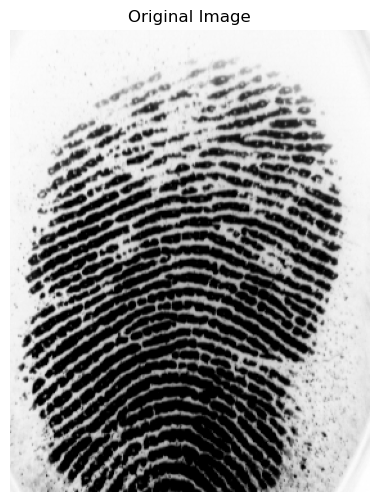

Blurred Image:


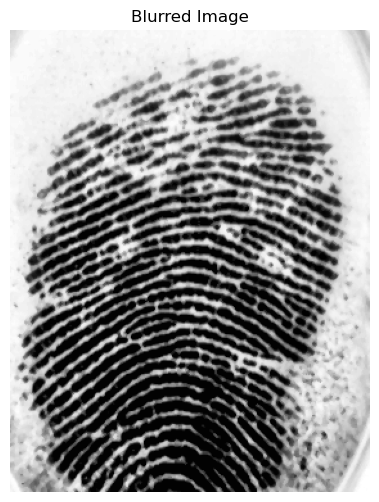

Opened Image:


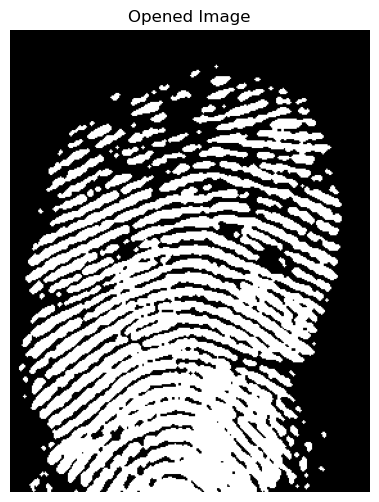

Raw Skeleton:


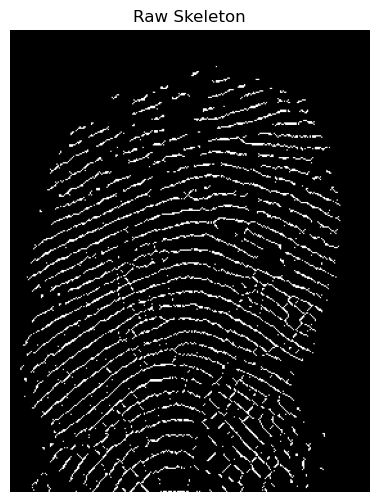

Connected Skeleton:


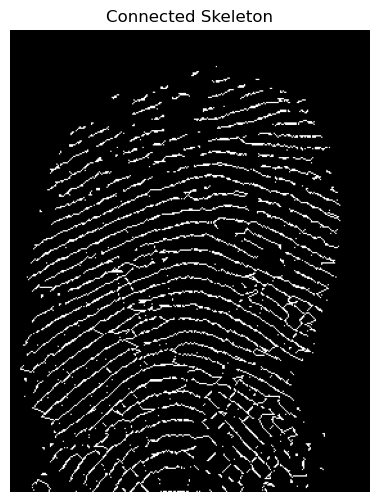

Final Skeleton:


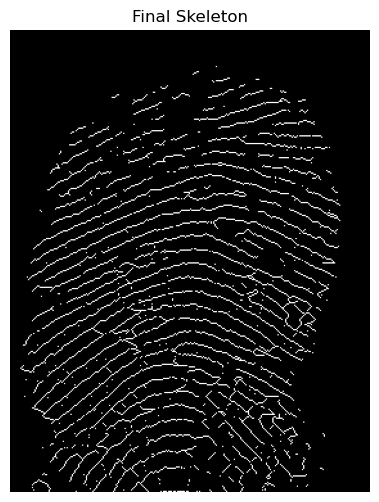

In [70]:
original_img, blurred_img, opened_img, raw_skeleton, connected_skeleton, final_skeleton = morphological_skeleton_improved('./Demo/L_5_1.bmp')

print("Original Image:")
plot_image("Original Image", original_img, cmap='gray')
print("Blurred Image:")
plot_image("Blurred Image", blurred_img, cmap='gray')
print("Opened Image:")
plot_image("Opened Image", opened_img, cmap='gray')
print("Raw Skeleton:")
plot_image("Raw Skeleton", raw_skeleton, cmap='gray')
print("Connected Skeleton:")
plot_image("Connected Skeleton", connected_skeleton, cmap='gray')
print("Final Skeleton:")
plot_image("Final Skeleton", final_skeleton, cmap='gray')

In [ ]:
def count_neighbors(img, i, j):
    """
    Zlicza liczbę sąsiadów piksela (i,j) w obrazie binarnym.

    Args:
        img: 2D ndarray, obraz binarny (1=linia, 0=tło)
        i, j: współrzędne piksela

    Returns:
        int: liczba sąsiadów
    """
    h, w = img.shape
    count = 0

    # Sprawdź wszystkich 8 sąsiadów
    for di in range(-1, 2):
        for dj in range(-1, 2):
            if di == 0 and dj == 0:  # Pomijamy środkowy piksel
                continue
            ni, nj = i + di, j + dj
            if 0 <= ni < h and 0 <= nj < w and img[ni, nj] > 0:
                count += 1

    return count

def get_crossing_number(img, i, j):
    """
    Oblicza crossing number (CN) dla piksela - liczbę przejść z 0 na 1
    w sąsiedztwie 8-connected wokół piksela (i,j).

    Args:
        img: 2D ndarray, obraz binarny
        i, j: współrzędne piksela

    Returns:
        int: crossing number
    """
    h, w = img.shape

    # Sąsiedzi w kolejności: N, NE, E, SE, S, SW, W, NW
    neighbors = []
    directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]

    for di, dj in directions:
        ni, nj = i + di, j + dj
        if 0 <= ni < h and 0 <= nj < w:
            neighbors.append(1 if img[ni, nj] > 0 else 0)
        else:
            neighbors.append(0)

    neighbors.append(neighbors[0])

    crossing_number = 0
    for k in range(8):
        if neighbors[k] == 0 and neighbors[k+1] == 1:
            crossing_number += 1

    return crossing_number

def detect_bifurcations(skeleton_img, min_ridge_length=10):
    """
    Wykrywa bifurkacje na obrazie szkieletu linii papilarnych.

    Bifurkacja to punkt, gdzie jedna linia papilarna rozdziela się na trzy.
    Charakteryzuje się:
    - Crossing number (CN) = 3
    - Dokładnie 3 sąsiadów w sąsiedztwie 8-connected

    Args:
        skeleton_img: 2D ndarray uint8, szkielet (1=linia, 0=tło)
        min_ridge_length: minimalna długość gałęzi aby uznać bifurkację za prawdziwą

    Returns:
        list: lista współrzędnych bifurkacji [(y, x), ...]
    """
    h, w = skeleton_img.shape
    bifurcations = []

    # Przeszukaj każdy piksel szkieletu
    for i in range(1, h-1):  # Omijamy brzegi
        for j in range(1, w-1):
            if skeleton_img[i, j] > 0:  # Jeśli to piksel linii
                # Zlicz sąsiadów
                neighbor_count = count_neighbors(skeleton_img, i, j)

                # Oblicz crossing number
                cn = get_crossing_number(skeleton_img, i, j)

                # Bifurkacja: CN = 3 (lub neighbor_count = 3)
                if cn == 3 or neighbor_count == 3:
                    # Dodatkowa walidacja - sprawdź czy to rzeczywiście bifurkacja
                    if is_valid_bifurcation(skeleton_img, i, j, min_ridge_length):
                        bifurcations.append((i, j))

    return bifurcations

def is_valid_bifurcation(img, i, j, min_length=10):
    """
    Sprawdza czy punkt (i,j) to rzeczywiście bifurkacja poprzez:
    1. Sprawdzenie czy ma dokładnie 3 gałęzie
    2. Sprawdzenie czy każda gałąź ma minimalną długość

    Args:
        img: obraz szkieletu
        i, j: współrzędny kandydata na bifurkację
        min_length: minimalna długość gałęzi

    Returns:
        bool: True jeśli to prawdziwa bifurkacja
    """
    # Znajdź wszystkie gałęzie wychodzące z tego punktu
    branches = find_branches_from_point(img, i, j)

    # Bifurkacja powinna mieć dokładnie 3 gałęzie
    if len(branches) != 3:
        return False

    # Sprawdź czy każda gałąź ma minimalną długość
    for branch in branches:
        if len(branch) < min_length:
            return False

    return True

def find_branches_from_point(img, start_i, start_j):
    """
    Znajduje wszystkie gałęzie wychodzące z danego punktu.

    Args:
        img: obraz szkieletu
        start_i, start_j: punkt startowy

    Returns:
        list: lista gałęzi, każda gałąź to lista punktów [(i,j), ...]
    """
    h, w = img.shape
    visited = np.zeros_like(img, dtype=bool)
    visited[start_i, start_j] = True

    branches = []

    # Znajdź wszystkich sąsiadów punktu startowego
    neighbors = []
    for di in range(-1, 2):
        for dj in range(-1, 2):
            if di == 0 and dj == 0:
                continue
            ni, nj = start_i + di, start_j + dj
            if 0 <= ni < h and 0 <= nj < w and img[ni, nj] > 0:
                neighbors.append((ni, nj))

    # Dla każdego sąsiada, śledź gałąź
    for ni, nj in neighbors:
        if not visited[ni, nj]:
            branch = trace_branch(img, ni, nj, visited.copy(), start_point=(start_i, start_j))
            if len(branch) > 1:  # Przynajmniej 2 punkty (łącznie z punktem startowym)
                branches.append(branch)

    return branches

def trace_branch(img, start_i, start_j, visited, start_point=None):
    """
    Śledzi gałąź od punktu startowego do końca.

    Args:
        img: obraz szkieletu
        start_i, start_j: punkt startowy śledzenia
        visited: maska odwiedzonych punktów
        start_point: punkt pochodzenia (bifurkacja), aby go pominąć

    Returns:
        list: lista punktów tworzących gałąź
    """
    h, w = img.shape
    branch = [(start_i, start_j)]
    visited[start_i, start_j] = True

    current_i, current_j = start_i, start_j

    while True:
        # Znajdź następny nieodwiedzony sąsiedni punkt
        next_point = None
        for di in range(-1, 2):
            for dj in range(-1, 2):
                if di == 0 and dj == 0:
                    continue
                ni, nj = current_i + di, current_j + dj

                # Pomijamy punkt startowy (bifurkację)
                if start_point and (ni, nj) == start_point:
                    continue

                if (0 <= ni < h and 0 <= nj < w and
                    img[ni, nj] > 0 and not visited[ni, nj]):
                    next_point = (ni, nj)
                    break
            if next_point:
                break

        if next_point is None:
            # Koniec gałęzi
            break

        current_i, current_j = next_point
        branch.append(next_point)
        visited[current_i, current_j] = True

    return branch

def detect_ridge_endings(skeleton_img):
    """
    Wykrywa końcówki linii papilarnych (ridge endings).

    Końcówka to punkt z:
    - Crossing number (CN) = 1
    - Dokładnie 1 sąsiadem

    Args:
        skeleton_img: 2D ndarray uint8, szkielet

    Returns:
        list: lista współrzędnych końcówek [(y, x), ...]
    """
    h, w = skeleton_img.shape
    endings = []

    for i in range(1, h-1):
        for j in range(1, w-1):
            if skeleton_img[i, j] > 0:
                neighbor_count = count_neighbors(skeleton_img, i, j)
                cn = get_crossing_number(skeleton_img, i, j)

                # Końcówka: CN = 1 lub neighbor_count = 1
                if cn == 1 or neighbor_count == 1:
                    endings.append((i, j))

    return endings

def visualize_minutiae(original_img, skeleton_img, bifurcations, endings, title="Minucje"):
    """
    Wizualizuje wykryte minucje na obrazie.

    Args:
        original_img: obraz oryginalny
        skeleton_img: szkielet linii papilarnych
        bifurcations: lista bifurkacji
        endings: lista końcówek
        title: tytuł wykresu
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Obraz oryginalny
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title("Obraz oryginalny")
    axes[0].axis('off')

    # Szkielet
    axes[1].imshow(skeleton_img, cmap='gray')
    axes[1].set_title("Szkielet")
    axes[1].axis('off')

    # Szkielet z minucjami
    axes[2].imshow(skeleton_img, cmap='gray')

    # Narysuj bifurkacje (czerwone kółka)
    if bifurcations:
        bif_y, bif_x = zip(*bifurcations)
        axes[2].scatter(bif_x, bif_y, c='red', s=50, marker='o',
                       label=f'Bifurkacje ({len(bifurcations)})')

    # Narysuj końcówki (niebieskie kwadraty)
    if endings:
        end_y, end_x = zip(*endings)
        axes[2].scatter(end_x, end_y, c='blue', s=50, marker='s',
                       label=f'Końcówki ({len(endings)})')

    axes[2].set_title(f"{title}")
    axes[2].legend()
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def advanced_bifurcation_detection(skeleton_img, min_ridge_length=8,
                                  noise_threshold=3, angle_threshold=30):
    """
    Zaawansowana detekcja bifurkacji z dodatkowymi filtrami.

    Args:
        skeleton_img: szkielet linii papilarnych
        min_ridge_length: minimalna długość gałęzi
        noise_threshold: próg do filtrowania szumu
        angle_threshold: minimalny kąt między gałęziami bifurkacji (w stopniach)

    Returns:
        list: lista współrzędnych bifurkacji
    """
    # Podstawowa detekcja
    basic_bifurcations = detect_bifurcations(skeleton_img, min_ridge_length)

    # Filtrowanie zaawansowane
    filtered_bifurcations = []

    for bi, bj in basic_bifurcations:
        # Znajdź gałęzie
        branches = find_branches_from_point(skeleton_img, bi, bj)

        if len(branches) == 3:
            # Sprawdź kąty między gałęziami
            angles = calculate_branch_angles(branches, (bi, bj))

            # Sprawdź czy kąty są wystarczająco duże
            min_angle = min(angles)
            if min_angle >= angle_threshold:
                filtered_bifurcations.append((bi, bj))

    return filtered_bifurcations

def calculate_branch_angles(branches, center_point):
    """
    Oblicza kąty między gałęziami bifurkacji.

    Args:
        branches: lista gałęzi
        center_point: punkt centralny bifurkacji

    Returns:
        list: lista kątów między sąsiednimi gałęziami
    """
    if len(branches) != 3:
        return []

    ci, cj = center_point

    # Oblicz wektory kierunkowe dla każdej gałęzi
    vectors = []
    for branch in branches:
        if len(branch) >= 2:
            # Weź pierwszy punkt gałęzi (po punkcie centralnym)
            bi, bj = branch[0]
            vector = (bi - ci, bj - cj)
            vectors.append(vector)

    if len(vectors) != 3:
        return []

    # Oblicz kąty między wszystkimi parami wektorów
    angles = []
    for i in range(len(vectors)):
        for j in range(i+1, len(vectors)):
            v1 = vectors[i]
            v2 = vectors[j]

            # Oblicz kąt między wektorami
            dot_product = v1[0] * v2[0] + v1[1] * v2[1]
            mag1 = np.sqrt(v1[0]**2 + v1[1]**2)
            mag2 = np.sqrt(v2[0]**2 + v2[1]**2)

            if mag1 > 0 and mag2 > 0:
                cos_angle = dot_product / (mag1 * mag2)
                cos_angle = np.clip(cos_angle, -1, 1)  # Zabezpieczenie przed błędami numerycznymi
                angle = np.arccos(cos_angle)
                angles.append(np.degrees(angle))

    return angles

def process_and_analyze_minutiae(hand, finger, data_dir, count=3):
    """
    Przetwarza obrazy odcisków palców i wykrywa minucje.

    Args:
        hand: 'r' lub 'l' (prawa/lewa ręka)
        finger: numer palca (1-5)
        data_dir: ścieżka do katalogu z danymi
        count: liczba obrazów do przetworzenia
    """
    # Import z poprzedniego kodu
    from scipy.ndimage import median_filter, binary_opening

    prefix = hand.upper()

    for idx in range(1, count+1):
        fname = f"{prefix}_{finger}_{idx}.bmp"
        path = os.path.join(data_dir, fname)

        if not os.path.isfile(path):
            print(f"Brak pliku: {fname}")
            continue

        try:
            print(f"\nPrzetwarzanie: {fname}")
            
            # Wczytaj obraz oryginalny
            img = Image.open(path)
            orig = np.array(img)

            # Konwersja do skali szarości
            gray = np.array(img.convert('L'))
            gray_filtered = median_filter(gray, size=3)
            
            skeleton = morphological_skeleton_improved(path)
            
            # Wykryj minucje
            bifurcations = detect_bifurcations(skeleton)
            endings = detect_ridge_endings(skeleton)

            # Zaawansowana detekcja bifurkacji
            advanced_bif = advanced_bifurcation_detection(skeleton)

            print(f"  Wykryto bifurkacji (podstawowo): {len(bifurcations)}")
            print(f"  Wykryto bifurkacji (zaawansowanie): {len(advanced_bif)}")
            print(f"  Wykryto końcówek: {len(endings)}")

            # Wizualizacja
            visualize_minutiae(gray_filtered, skeleton, advanced_bif, endings,
                             title=f"Minucje - {fname}")

        except Exception as e:
            print(f"Błąd podczas przetwarzania {fname}: {str(e)}")
            import traceback
            traceback.print_exc()


    


Przetwarzanie: L_5_1.bmp
  Wykryto bifurkacji (podstawowo): 30
  Wykryto bifurkacji (zaawansowanie): 36
  Wykryto końcówek: 657


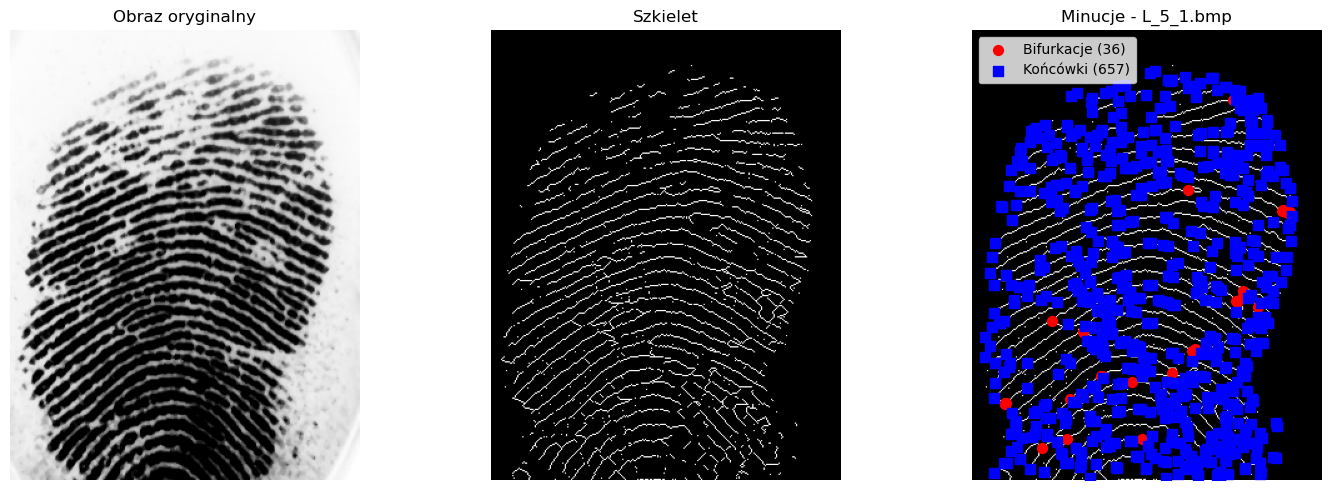


Przetwarzanie: L_5_2.bmp
  Wykryto bifurkacji (podstawowo): 44
  Wykryto bifurkacji (zaawansowanie): 50
  Wykryto końcówek: 577


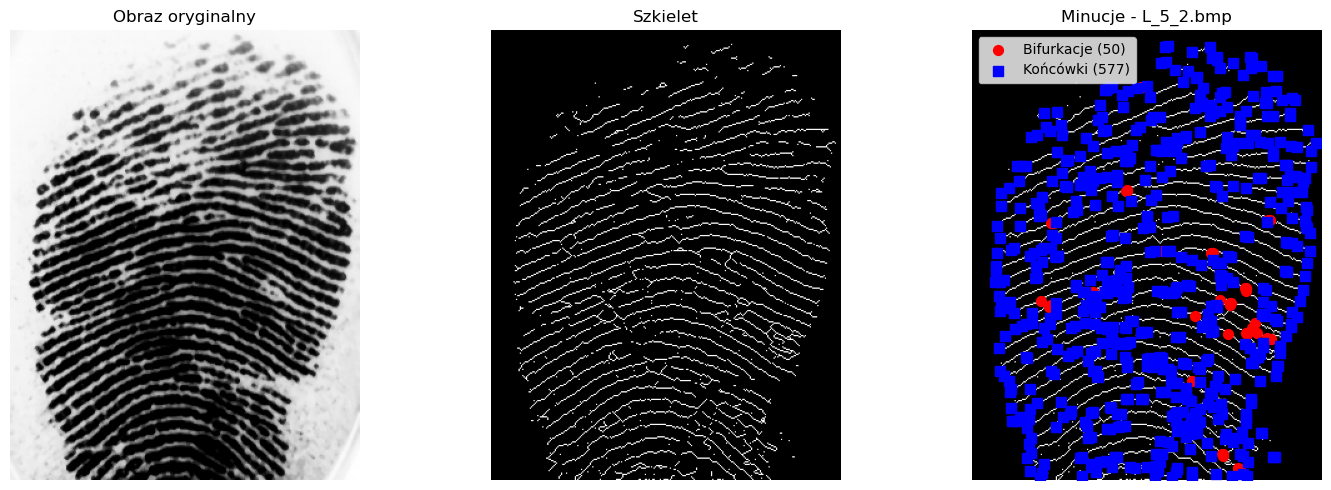


Przetwarzanie: L_5_3.bmp
  Wykryto bifurkacji (podstawowo): 49
  Wykryto bifurkacji (zaawansowanie): 64
  Wykryto końcówek: 562


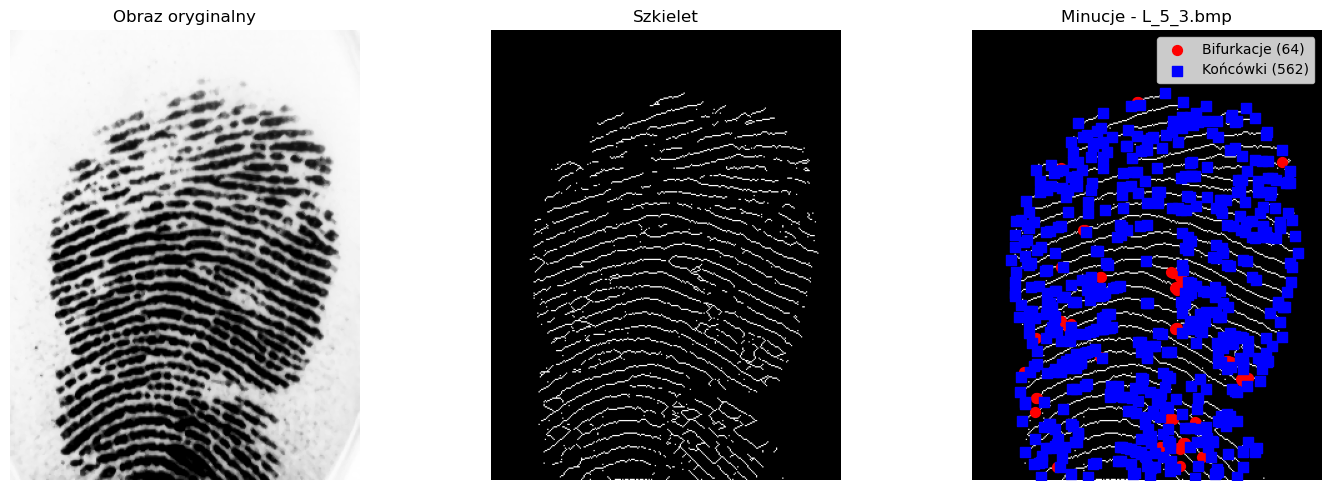

In [66]:
data_dir = './Demo'

# Przetwórz obrazy i wykryj minucje
process_and_analyze_minutiae('L', '5', data_dir, count=3)